In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../../src/')
from findpoint import findpoint
import ModelEvaLib as me
from namelist import *

In [2]:
chem = xr.open_dataset(cmaqfile)

PM25 = chem.PM25

lat = chem.latitude
lon = chem.longitude

In [3]:
obspath = 'D:/data/Project_Xiaoshan/202209/obsdata/sites_2209/'
sitename = [filename.split('-')[1].split('.')[0] for filename in os.listdir(obspath) if (filename.endswith('.xlsx')) & (filename.startswith('杭州'))]
citysitename = [os.path.splitext(filename)[0] for filename in os.listdir(obspath) if (filename.endswith('.xlsx')) & (filename.startswith('杭州'))]
siteloc = pd.read_excel('D:/data/Project_Xiaoshan/杭州站点.xlsx',header=0,index_col=1)
lono = siteloc['经度']
lato = siteloc['纬度']

df = pd.DataFrame(columns=citysitename,index=pd.date_range('2022-09-01','2022-09-30T23',freq='h'))

for name in citysitename:
    obsxlsx = pd.read_excel(obspath + name + '.xlsx',index_col=0)
    df[name]=obsxlsx['PM2.5']

df = df.interpolate(method='linear')

In [4]:
x_index=[]
y_index=[]

for name in sitename:
    out_x, out_y = findpoint(lono[name],lato[name],PM25)
    x_index.append(out_x)
    y_index.append(out_y)
nr = PM25.isel(x=x_index, y=y_index)

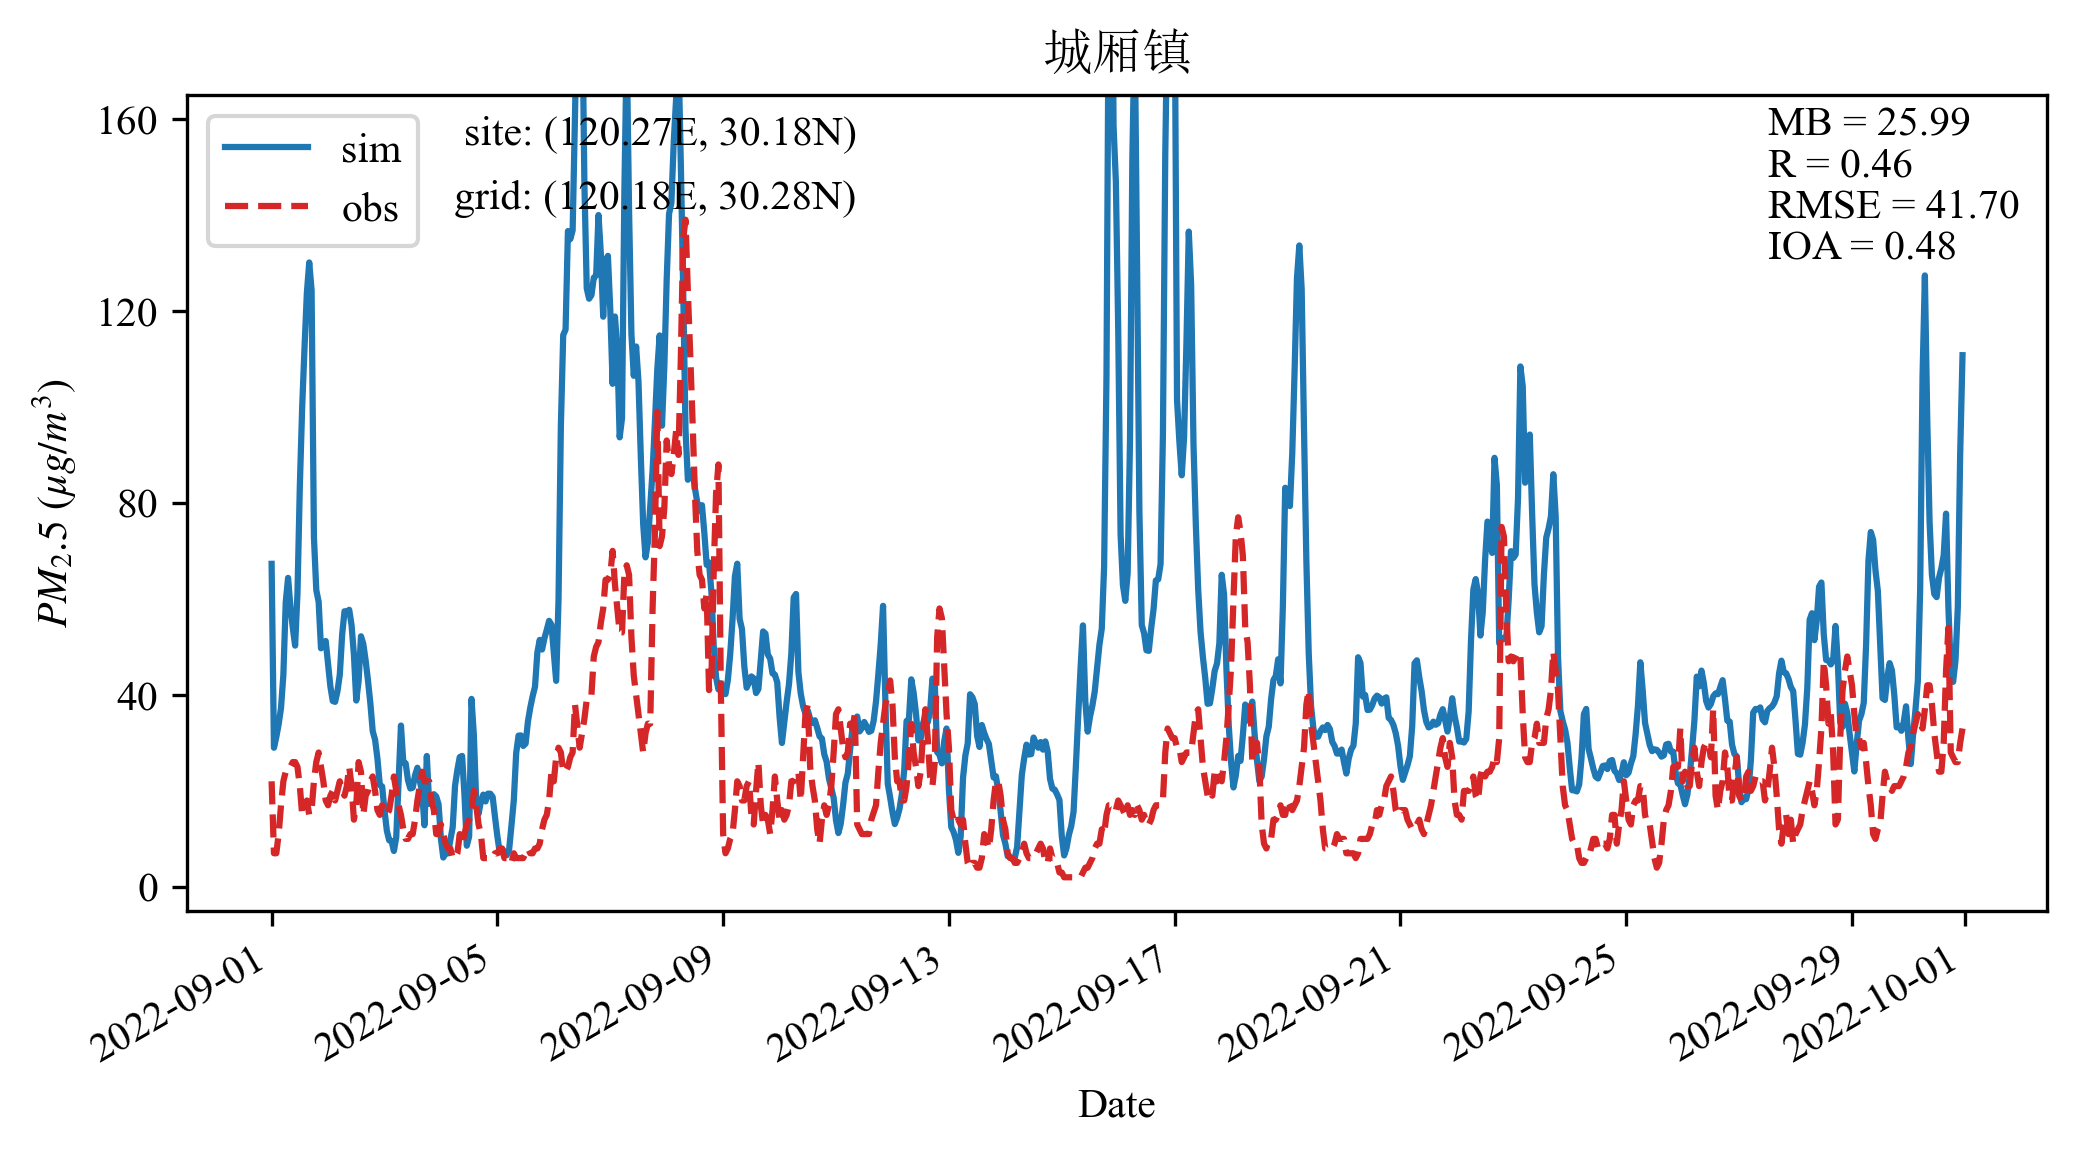

In [5]:
name = '城厢镇'
citysite = '杭州-城厢镇'
isite = 9

fig = plt.figure(figsize=(8,4),dpi=300)
ax = fig.subplots(1,1)

sim = nr[:,0,isite,isite]
obs = df[citysite]

sim.plot(ax=ax,linestyle='-',label='sim',color='tab:blue')
obs.plot(ax=ax,linestyle='--',label='obs',color='tab:red')

mb = np.array(np.mean(sim)-np.mean(obs))
r = pd.DataFrame({'A':sim,'B':obs}).corr().iloc[0,1]
rmse = me.cal_RMSE(obs,sim.data)
ioa = me.cal_IOA(obs,sim.data)

ax.text(x=0.85,y=0.95,s='MB = '+str(f"{mb:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.85,y=0.9,s='R = '+str(f"{r:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.85,y=0.85,s='RMSE = '+str(f"{rmse:.2f}"),ha='left',transform=ax.transAxes)
ax.text(x=0.85,y=0.8,s='IOA = '+str(f"{ioa:.2f}"),ha='left',transform=ax.transAxes)

ax.legend(loc=2)
ax.set_title(name,fontdict={'fontfamily':'SimSun'})
loctxt = 'site: ('+str(f"{lono[name]:.2f}")+'E, '+str(f"{lato[name]:.2f}")+'N)'
gridtxt = 'grid: ('+str(f"{(sim.longitude.values.astype(float)):.2f}")+'E, '+str(f"{(sim.latitude.values.astype(float)):.2f}")+'N)'
ax.text(x=0.36,y=0.94,s=loctxt,ha='right',transform=ax.transAxes)
ax.text(x=0.36,y=0.86,s=gridtxt,ha='right',transform=ax.transAxes)
ax.set_yticks(np.arange(0,161,40))
ax.set_ylim(-5,165)
ax.set_ylabel(f'$PM_{2.5}$ ($\mu$$g/m^3$)')
ax.set_xlabel('Date')

plt.show()

In [6]:
isite = 0
for name in citysitename:
    fig = plt.figure(figsize=(8,4),dpi=300)
    ax = fig.subplots(1,1)
    sim = nr[:,0,isite,isite]
    obs = df[name]
    
    sim.plot(ax=ax,linestyle='-',label='sim',color='tab:blue')
    obs.plot(ax=ax,linestyle='--',label='obs',color='tab:red')
    
    mb = np.array(np.mean(sim)-np.mean(obs))
    r = pd.DataFrame({'A':sim,'B':obs}).corr().iloc[0,1]
    rmse = me.cal_RMSE(obs,sim.data)
    ioa = me.cal_IOA(obs,sim.data)
    
    ax.text(x=0.85,y=0.95,s='MB = '+str(f"{mb:.2f}"),ha='left',transform=ax.transAxes)
    ax.text(x=0.85,y=0.9,s='R = '+str(f"{r:.2f}"),ha='left',transform=ax.transAxes)
    ax.text(x=0.85,y=0.85,s='RMSE = '+str(f"{rmse:.2f}"),ha='left',transform=ax.transAxes)
    ax.text(x=0.85,y=0.8,s='IOA = '+str(f"{ioa:.2f}"),ha='left',transform=ax.transAxes)

    ax.legend(loc=2)
    ax.set_title(name,fontdict={'fontfamily':'SimSun'})
    # loctxt = 'site: ('+str(f"{lono[name]:.2f}")+'E, '+str(f"{lato[name]:.2f}")+'N)'
    # gridtxt = 'grid: ('+str(f"{(sim.longitude.values.astype(float)):.2f}")+'E, '+str(f"{(sim.latitude.values.astype(float)):.2f}")+'N)'
    # ax.text(x=0.36,y=0.94,s=loctxt,ha='right',transform=ax.transAxes)
    # ax.text(x=0.36,y=0.86,s=gridtxt,ha='right',transform=ax.transAxes)
    ax.set_yticks(np.arange(0,161,40))
    ax.set_ylabel(f'$PM{2.5}$ ($\mu$$g/m^3$)')
    ax.set_xlabel('Date')
    ax.set_ylim(-5,165)
    
    path = 'D:/Academic/Project/Xiaoshan/XS_2209/figures/逐站点/PM25/'
    plt.savefig(path+name+'.png')
    plt.close()
    isite += 1